`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   


# Машинное обучение "без учителя". Задача кластеризации
## Работу выполнила: Бобина Татьяна Сергеевна


Содержание:
* как пользоваться инструментами визуального анализа для предварительной интерпретации кластеров
* как проводить кластерный анализ
* как строить прогноз принадлежности к кластерам новых наблюдений
* как оценивать точность кластеризации
Модели: иерархический и неиерархический кластерный анализ

Данные: load_iris

In [2]:
import numpy as np
import pandas as pd
# процедура стандартизации
from sklearn.preprocessing import StandardScaler
# алгоритм k-средних
from sklearn.cluster import KMeans
# алгоритм k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
# дендрограмма
from scipy.cluster.hierarchy import dendrogram, linkage
# дендрограмма, расчет матрицы расстояний
from scipy.spatial.distance import pdist
# метрики
from sklearn import metrics 
# кластерные силуэты
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from matplotlib import pyplot as plt
import seaborn
seaborn.set_theme()
from sklearn.datasets import load_iris 
data = load_iris()
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

Данные в примере:

* sepal length (cm) - длина чашелистика (см)
* sepal width (cm) - ширина чашелистика (см)
* petal length (cm) - длина лепестка (см)
* petal width (cm) - ширина лепестка (см)

Задача состоит в разделении ирисов на группы в зависимости от показателей(sepal length (cm), sepal width (cm))

In [3]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
df = df[['sepal length (cm)', 'sepal width (cm)']]
df.columns = ["sepal_length", "sepal_width"]

In [5]:
df

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
...,...,...
145,6.7,3.0
146,6.3,2.5
147,6.5,3.0
148,6.2,3.4


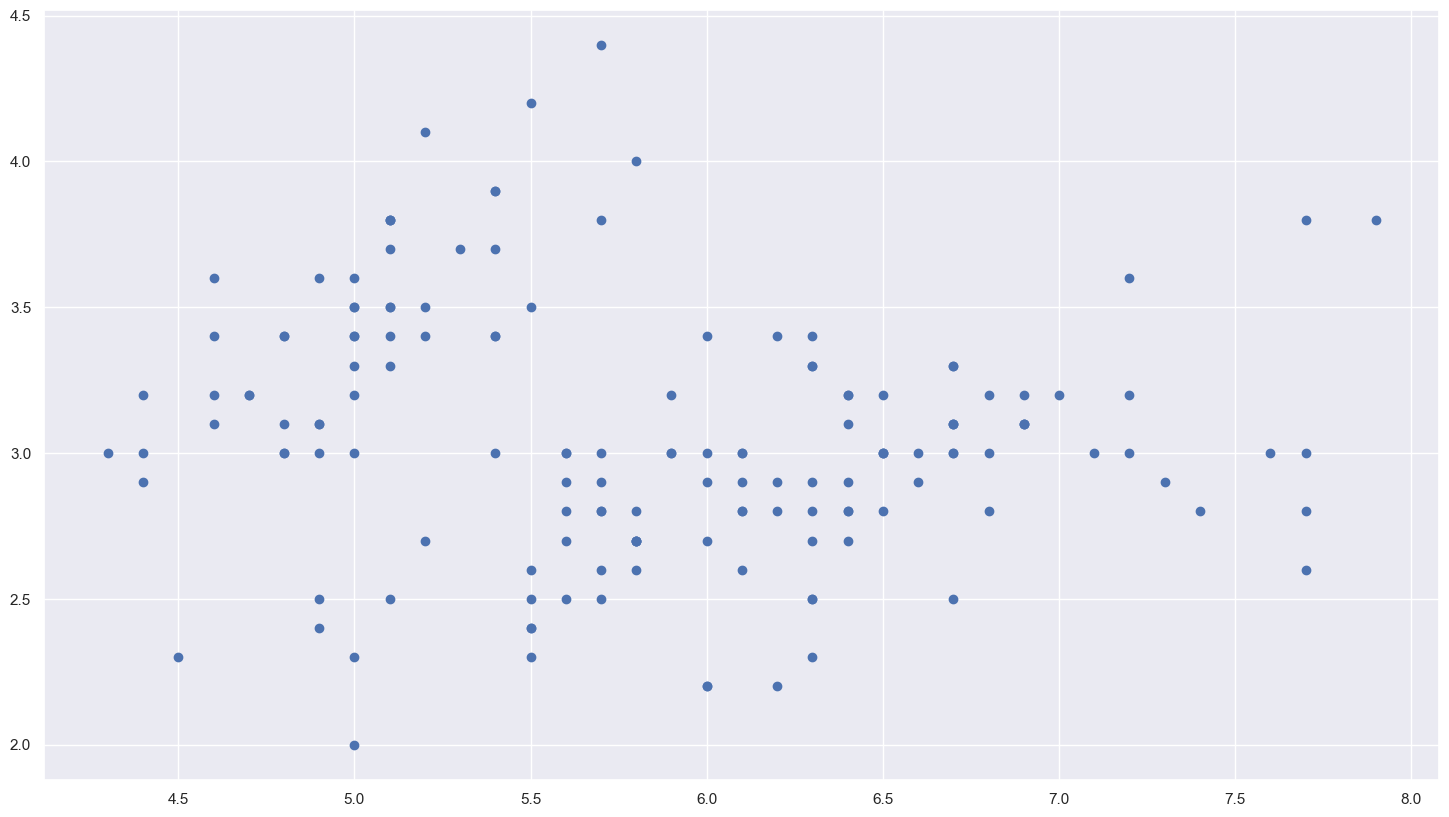

In [7]:
plt.figure(figsize=(18,10))
plt.scatter(df.sepal_length, df.sepal_width)

В нашем примере наблюдения визуально сгруппированы на 4 группы. Тем не менее, рассмотрим метод для определения наилучшего количества кластеров.

# Определение оптимального количества кластеров для метода локтя
Одна из основных трудностей в обучении без учителя состоит в том, что мы не знаем точного ответа. В нашем наборе данных нет установленных данных о метках классов, поэтому для количественного определения качества кластеризации нам нужно использовать внутренние метрики - такие как внутрикластерная SSE (искажение или инерция).
Основываясь на внутрикластерной SSE, мы можем применить графический инструмент, так называемый метод локтя, для оценки оптимального числа k кластеров для поставленной задачи. Интуитивно мы можем сказать, что если k увеличивается, то искажение уменьшается. Это вызвано тем, что образцы будут ближе к центроидам, которым они назначены. В основе метода локтя лежит идея, которая состоит в том, чтобы идентифицировать значение k в точке, где искажение начинает увеличиваться быстрее всего, что станет понятнее, если мы построим график искажения для разных значений k.


C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: 

Text(0, 0.5, 'Искажение ')

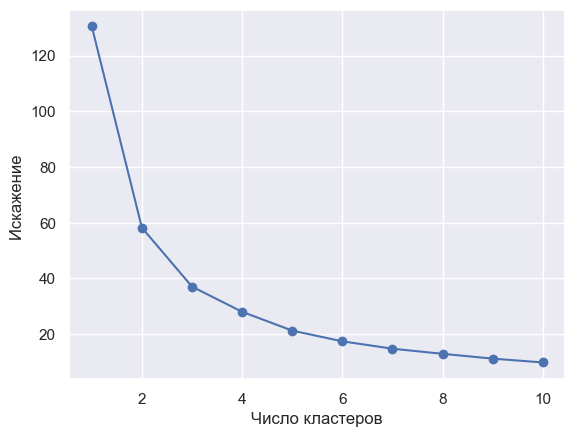

In [8]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на следующем выше графике, локоть расположен в k = 4, что свидетельствует о том, что k = 4 является хорошим выбором для этого набора данных

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


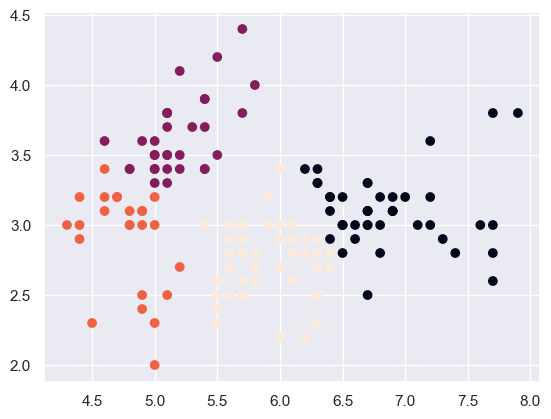

In [16]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(df.values)
plt.scatter(df.sepal_length, df.sepal_width, c=kmeans.labels_)

Bизуальный анализ говорит о наличии 3 различных групп. Сделаем и такое построение:

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


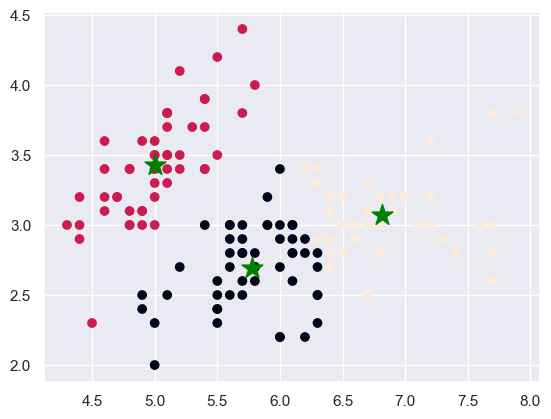

In [19]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
plt.scatter(df.sepal_length, df.sepal_width, c=kmeans.labels_)
# нарисуем центроиды
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=250, marker= '*', c = 'green', label = 'центроиды')

Теперь видим, что каждая группа точек покрашена в цвет соответствующего кластера, а центроиды расположены внутри множества точек. Тем не менее, попробуем оценить качество кластеризации в обоих вариантах.

# Количественная оценка качества кластеризации
Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.

Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Средний коэффициент силуэта --  0.4450525692083638


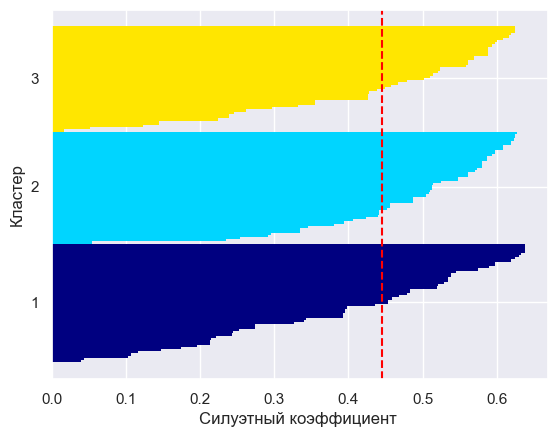

In [22]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

cluster_labels = np.unique(y_km) 
n_clusters = cluster_labels.shape[0] 
silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')

# изобразим график силуэтов
y_ax_lower , y_ax_upper = 0, 0 
yticks = [] 
for i, c in enumerate(cluster_labels): 
    c_silhouette_vals = silhouette_vals[y_km == c] 
    c_silhouette_vals.sort() 
    y_ax_upper += len(c_silhouette_vals) 
    color = cm.jet(float(i) / n_clusters) 
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals , 
             height=1.0, 
             edgecolor='none', 
             color=color) 
    yticks.append((y_ax_lower + y_ax_upper) / 2) 
    y_ax_lower += len(c_silhouette_vals) 
silhouette_avg = np.mean(silhouette_vals) 
    
plt.axvline(silhouette_avg, color= "red", linestyle="--" ) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel ('Кластер') 
plt.xlabel('Силуэтный коэффициент ' ) 
plt.show() 

Средний коэффициент силуэта весьма близок к 0.5 , что говорит о относительным качестве кластеризации. Если силуэты зрительно значительно отличаются друг от друга по длине, то это является признаком субоптимальной кластеризации. Как правило, в этом случае центроиды кластеров стоят отдельно от множества точек кластера. Посчитаем средний силуэтный коэффициент для кластеризации 
k=4.

In [24]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Средний коэффициент силуэта --  0.4248889536419922


Его значение немного ниже, чем в предыдущем случае. Формально k=3 - более оптимальное разбиение.

# Сравнение результатов на обучающей и тестовой выборке
Посмотрим, как прогнозировать новых наблюдений принадлежность к кластерам, построенным по обучающим данным. Сравним значения средних силуэтных коэффициентов.

В обучающей выборке - 80% исходных наблюдений.

In [25]:
DF = pd.DataFrame(data.data, columns=data.feature_names)
DF.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Добавляем к выборке дополнительный показатель.

In [26]:
DF = DF[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]
DF.columns = ["sepal_length", "sepal_width", "petal_length"]

In [27]:
DF

,sepal_length,sepal_width,petal_length
0,5.1,3.5,1.4
1,4.9,3.0,1.4
2,4.7,3.2,1.3
3,4.6,3.1,1.5
4,5.0,3.6,1.4
...,...,...,...
145,6.7,3.0,5.2
146,6.3,2.5,5.0
147,6.5,3.0,5.2
148,6.2,3.4,5.4


In [28]:
DF_train = DF.sample(frac=0.8)

# данные для прогнозов
DF_predict = DF.drop(DF_train.index)

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: 

Text(0, 0.5, 'Искажение ')

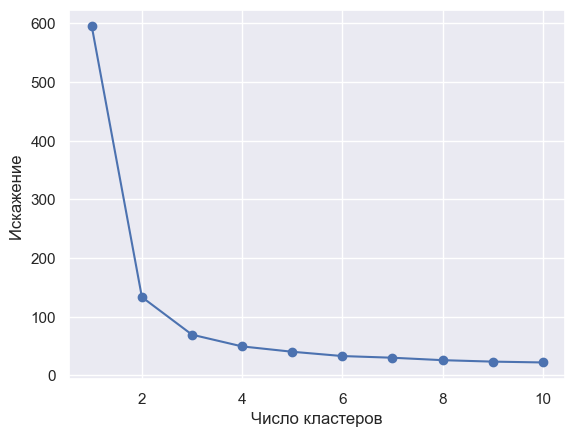

In [29]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(DF)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на следующем выше графике, заметных изменений не обнаружилось.

Обучаем алгоритм и считаем средний силуэтный коэффициент.

In [30]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(DF_train.values)
y_km_train = kmeans.fit_predict(DF_train) 
silhouette_vals = silhouette_samples(DF_train, y_km_train, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Средний коэффициент силуэта --  0.5426144380745519


In [31]:
y_km_predict = kmeans.fit_predict(DF_predict) 
silhouette_vals = silhouette_samples(DF_predict, y_km_predict, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Средний коэффициент силуэта --  0.5862478392183824


Применяем модель к новым данным. Значение среднего силуэтного коэффициента незначительно ухудшилось.

# Статистический анализ получившихся кластеров

In [32]:
# снова работаем со всей выборкой
# добавляем метки кластеров в качестве нового столбца к фрейму
kmeans = KMeans(n_clusters=3,random_state=0).fit(DF.values)
DF["KM"] = kmeans.fit_predict(DF) 

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


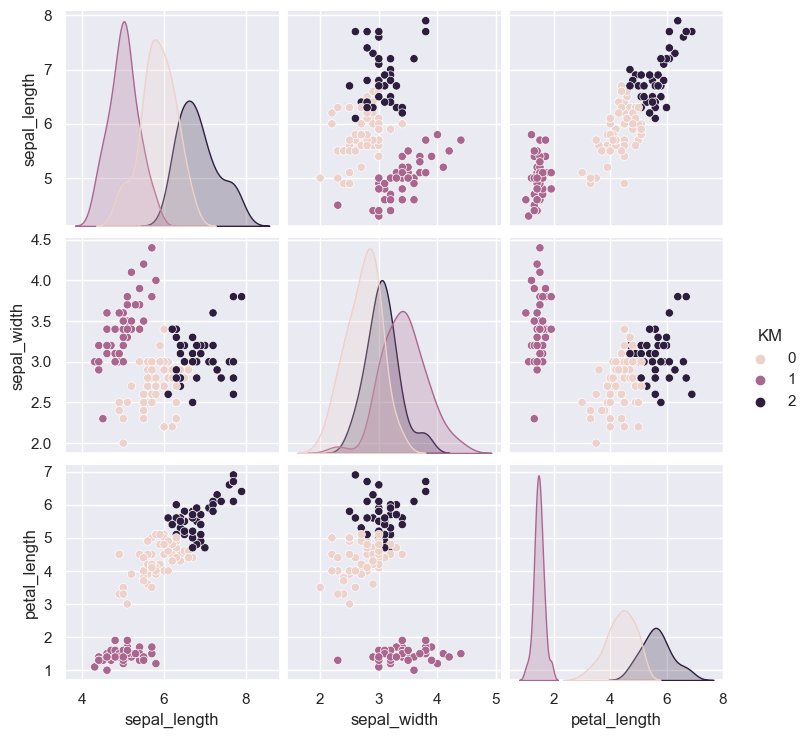

In [35]:
seaborn.pairplot(DF, hue='KM')
plt.show()

Визуально кластеры немного отличаются друг от друга. Судя по графикам плотности, по показателю petal_length имеют различия, а по sepal_length и sepal_width имеют некоторые сходства. По диаграммам разброса видно, что оба кластера образуют не совсем плотное множество точек, разбиение нестрогое.

In [47]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy: 0.23333333333333334


Из оценки кластеризации следует, что алгоритм (при разбиении на 3 кластера) достиг не высокой точности в своей работе

In [42]:
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy: 0.88


Из оценки кластеризации следует, что алгоритм (при разбиении на 3 кластера) достиг высокой точности в своей работе, указывая правильную категоризацию большинства объектов данных.